In [1]:
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import time
import diffusion_pde as dpde
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
import wandb
from omegaconf import OmegaConf
from pathlib import Path
from skopt import gp_minimize

In [2]:
root_path = dpde.utils.get_repo_root()
#cfg_rel_path = "logs/hydra/2025-11-04_15-58-37_heat-final-log/.hydra/config.yaml" # log timing
cfg_rel_path = "logs/hydra/2025-11-19_12-32-13/.hydra/config.yaml"
config_path = root_path / cfg_rel_path
cfg = OmegaConf.load(config_path)

res = dpde.utils.ResultsObject(cfg_path=config_path)

model_path = res.model_path
data_path = res.data_path
test_path = Path("/home/s204790/dynamical-pde-diffusion/data/heat_lineart_validate.hdf5")
#model_path.exists(), data_path.exists(), test_path.exists()

In [3]:
#cfg = OmegaConf.load("/home/s204790/dynamical-pde-diffusion/conf/dataset/heat_eq.yaml")
#print(OmegaConf.to_container(cfg.validation, resolve=True))
#print(cfg.validation.func_kwargs.seed)
#val_cfg = cfg.validation.get("func_kwargs", {})
#print(val_cfg)

In [4]:
DOWNLOAD_FROM_WANDB = False

pretrained_dir = root_path / "pretrained_models"
if DOWNLOAD_FROM_WANDB:
    model_path = res.get_wandb_model(root=pretrained_dir / "wandb_test", version="latest")
print(f"Model path: {model_path}")

Model path: /home/s204790/dynamical-pde-diffusion/pretrained_models/heat_heat_logt_unet_v2.pth


In [5]:
LOAD_TRAIN_DATA = False

if LOAD_TRAIN_DATA:
    with h5py.File(data_path, "r") as f:
        attrs = dict(f.attrs)
        data_A = f["A"][:]  # (N, 1, S, S)
        data_U = f["U"][:]  # (N, 1, S, S, steps+1)
        data_labels = f["labels"][:]  # (N,)
        t_steps = f["t_steps"][:]  # (steps+1,)
    print("A shape: ", data_A.shape)  # (N, 1, S, S)
    print("U shape: ", data_U.shape)  # (N, 1, S, S, steps+1)
    print("Labels shape: ", data_labels.shape)  # (N,)
    print("t_steps shape: ", t_steps.shape)  # (steps+1,)
    print("\nOther attributes: ")
    [print(f"  {key}: {val}") for key, val in attrs.items()];
    print(f"all data finite: {np.isfinite(data_U).all()}, nan count: {np.isnan(data_U).sum()}")
    print(f"data min: {data_U.min():<.4f}, max: {data_U.max():<.4f}, mean: {data_U.mean():<.4f}")
    print("U file size: ", data_U.nbytes / (1024**2), " MB")

In [6]:
with h5py.File(test_path, "r") as f:
    attrs = dict(f.attrs)
    data_A = f["A"][:]  # (N, 1, S, S)
    data_U = f["U"][:]  # (N, 1, S, S, steps+1)
    data_labels = f["labels"][:]  # (N,)
    t_steps = f["t_steps"][:]  # (steps+1,)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

edm = dpde.utils.get_net_from_config(cfg)
edm.load_state_dict(torch.load(model_path, weights_only=True))

<All keys matched successfully>

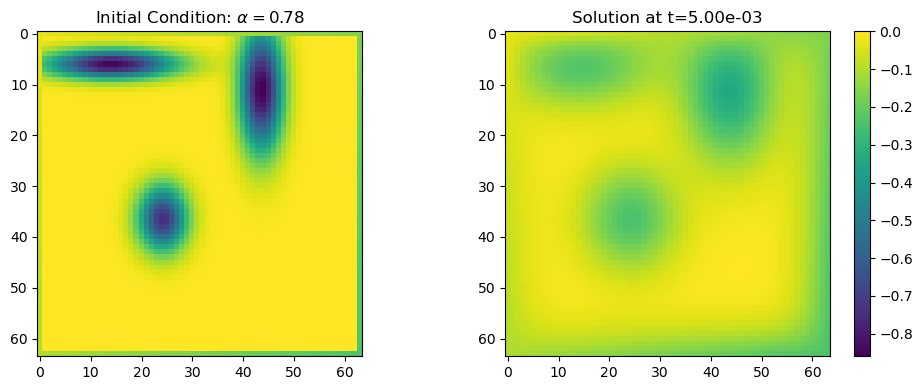

In [24]:
idx = 5     # which sample to visualize
t_idx = 1   # which time step to visualize

T = t_steps[t_idx].item()
alpha = data_labels[idx, 0].item()
A = data_A[idx, 0]  # (S, S)
U = data_U[idx, 0, :, :, t_idx]  # (S, S)

vmin, vmax = min(A.min(), U.min()), max(A.max(), U.max())
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
im0 = axs[0].imshow(A, cmap="viridis", vmin=vmin, vmax=vmax)
axs[0].set_title(f"Initial Condition: $\\alpha={alpha:.2f}$")
im1 = axs[1].imshow(U, cmap="viridis", vmin=vmin, vmax=vmax)
axs[1].set_title(f"Solution at t={T:.2e}")
fig.colorbar(im1, ax=axs[1])
plt.tight_layout()
plt.show()

In [25]:
sample_shape = cfg.dataset.sampling.sample_shape
generator = torch.Generator().manual_seed(0)

interior_a = 1.0
interior_u = 0.0
boundary_a = boundary_u = 0.5
same_boundary = True
boundary_obs_a = dpde.validation.random_boundary_mask(sample_shape[1], sample_shape[2], frac_obs=boundary_a)
if same_boundary:
    boundary_obs_u = boundary_obs_a[:]
else:
    boundary_obs_u = dpde.validation.random_boundary_mask(sample_shape[1], sample_shape[2], frac_obs=boundary_u)
interior_obs_a = dpde.validation.random_interior_mask(sample_shape[1], sample_shape[2], frac_obs=interior_a)
interior_obs_u = dpde.validation.random_interior_mask(sample_shape[1], sample_shape[2], frac_obs=interior_u)

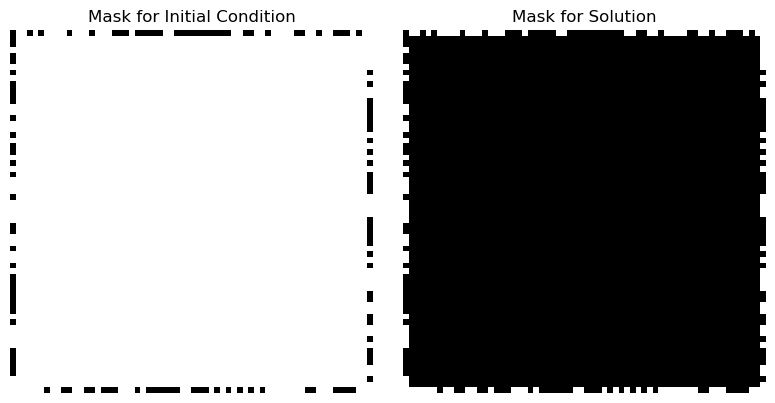

In [26]:
mask_a = dpde.validation.combine_masks(boundary_obs_a, interior_obs_a)
mask_u = dpde.validation.combine_masks(boundary_obs_u, interior_obs_u)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
im0 = axs[0].imshow(mask_a.cpu(), cmap="gray", vmin=0, vmax=1)
axs[0].set_title("Mask for Initial Condition")
im1 = axs[1].imshow(mask_u.cpu(), cmap="gray", vmin=0, vmax=1)
axs[1].set_title("Mask for Solution")
for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [27]:
def X_and_dXdt(net, x, sigma, labels):
    sigma_det = sigma.detach()
    labels_det = labels.detach()

    t0 = labels_det[:, 0]

    def f(t):
        lbl = labels_det.clone()
        lbl[:, 0] = t
        return net(x, sigma_det, lbl)

    X, dXdt = torch.func.jvp(
        f,
        (t0,),
        (torch.ones_like(t0),),
    )
    del sigma_det, labels_det, t0, f
    
    return X, dXdt

In [28]:
def X_and_dXdt_fd(net, x, sigma, labels, eps=1e-5):
    lbl_p = labels.clone(); lbl_m = labels.clone()
    lbl_p[:, 0] += eps
    lbl_m[:, 0] -= eps
    up = net(x, sigma, lbl_p)
    um = net(x, sigma, lbl_m)
    u0 = net(x, sigma, labels)
    dudt_fd = (up - um) / (2*eps)

    del lbl_p, lbl_m, up, um
    
    return u0, dudt_fd

In [39]:
out_and_grad_fun = X_and_dXdt_fd

In [40]:
def edm_sampler2(
    net,            # EDMWrapper (calls Unet inside)
    device,         # device to run the sampler on  
    sample_shape,   # (B, C, H, W) shape of samples
    loss_fn,        # loss function to compute gradients
    loss_fn_kwargs, # extra args to pass to loss function
    labels,         # (B, label_dim) extra conditioning your Unet expects; use zeros if None
    zeta_a=1.0,     # weight for obs_a loss
    zeta_u=1.0,     # weight for obs_u loss
    zeta_pde=1.0,   # weight for pde loss
    num_steps=18,
    sigma_min=0.002,
    sigma_max=80.0,
    rho=7.0,
    to_cpu=True,
    generator=None,
    return_losses=False,
):
    dtype_f = torch.float32     # net runs in fp32
    dtype_t = torch.float64     # keep time grid in fp64 for stability, as in EDM

    B = sample_shape[0]
    
    net.to(device=device)
        
    labels = labels.to(device=device, dtype=dtype_f)    # move labels to correct device and dtype

    if generator is None:
        generator = torch.Generator(device=device)

    # Initial sample at sigma_max
    latents = torch.randn(sample_shape, device=device, generator=generator)
    
    # Move loss function kwargs to correct device and dtype
    loss_kwargs = loss_fn_kwargs.copy()
    for key, val in loss_fn_kwargs.items():
        if isinstance(val, torch.Tensor):
            loss_kwargs[key] = val.clone().to(device=device, dtype=dtype_t)

    # Discretize sigmas per EDM (Karras et al. 2022), t_N = 0 appended.
    step_idx = torch.arange(num_steps, dtype=dtype_t, device=device)
    sigmas = (sigma_max**(1.0/rho) + step_idx/(num_steps-1) * (sigma_min**(1.0/rho) - sigma_max**(1.0/rho)))**rho
    sigmas = getattr(net, "round_sigma", lambda x: x)(sigmas)
    sigmas = torch.cat([sigmas, torch.zeros_like(sigmas[:1])])  # length N+1, last = 0

    # Initialize x at sigma_0
    x_next = (latents.to(dtype_t) * sigmas[0])

    losses = torch.zeros((num_steps, 4))  # for debugging
    
    for i, (sigma_cur, sigma_next) in enumerate(zip(sigmas[:-1], sigmas[1:])):  # i = 0..N-1
        x_cur = x_next.detach().clone()
        x_cur.requires_grad = True
        # Euler step to t_next
        x_N, dxdt = out_and_grad_fun(net, x_cur.to(dtype_f), torch.full((B,), sigma_cur, device=device, dtype=dtype_f), labels)
        x_N, dxdt = x_N.to(dtype_t), dxdt.to(dtype_t)
        
        d_cur = (x_cur - x_N) / sigma_cur
        x_next = x_cur + (sigma_next - sigma_cur) * d_cur
        # Heun (2nd-order) correction unless final step
        if i < num_steps - 1:
            x_N, dxdt = out_and_grad_fun(net, x_next.to(dtype_f), torch.full((B,), sigma_next, device=device, dtype=dtype_f), labels)
            x_N, dxdt = x_N.to(dtype_t), dxdt.to(dtype_t)
            d_prime = (x_next - x_N) / sigma_next
            x_next = x_cur + (sigma_next - sigma_cur) * (0.5 * d_cur + 0.5 * d_prime)

        # Compute losses

        loss_pde, loss_a, loss_obs_u = loss_fn(x_N, dxdt, **loss_kwargs)
        
        if i <= 0.8 * num_steps:
            w_a, w_u, w_pde = zeta_a, zeta_u, zeta_pde
        else:
            w_a, w_u, w_pde = 0.1 * zeta_a, 0.1 * zeta_u, zeta_pde
        
        loss_comb = w_a * loss_a + w_u * loss_obs_u + w_pde * loss_pde
        grad_x = torch.autograd.grad(loss_comb, x_cur, retain_graph=False)[0]
        x_next = x_next - grad_x
        
        losses[i] = torch.tensor([loss_a.item(), loss_obs_u.item(), loss_pde.item(), loss_comb.item()])

        del x_cur, x_N, dxdt, d_cur, loss_pde, loss_a, loss_obs_u, loss_comb, grad_x
    

    # Return at sigma=0 in fp32
    x = x_next.to(dtype_f).detach()
    if to_cpu:
        x = x.cpu()

    losses = losses.detach().cpu().numpy() if return_losses else None

    net.to(device=torch.device("cpu"))
    
    del x_next, loss_kwargs

    torch.cuda.empty_cache()
    torch.cuda.synchronize()
    
    return x, losses

In [41]:
obs_a = torch.tensor(A)
obs_u = torch.tensor(U)

dx = 1. / (A.shape[-1]-1)
ch_a = 1

sample_shape = (16, 2, 64, 64)

zeta_a = 30.0
zeta_u = 10.0
zeta_pde = 0.5

num_steps = 40

t_cond = torch.ones(sample_shape[0]) * T
alpha_cond = torch.ones_like(t_cond) * alpha
labels = torch.stack([t_cond, alpha_cond], dim=-1)

loss_fn_kwargs = {
    "obs_a": obs_a,
    "obs_u": obs_u,
    "mask_a": mask_a,
    "mask_u": mask_u,
    "dx": dx,
    "dy": dx,
    "ch_a": ch_a,
    "labels": alpha_cond,
}

torch.backends.cudnn.conv.fp32_precision = 'tf32'

#for i in range(10):
samples, losses = edm_sampler2(
    net=edm,
    device=device,
    sample_shape=sample_shape,
    loss_fn=dpde.sampling.heat_loss,
    loss_fn_kwargs=loss_fn_kwargs,
    labels=labels,
    zeta_a=zeta_a,
    zeta_u=zeta_u,
    zeta_pde=zeta_pde,
    num_steps=num_steps,
    to_cpu=True,
    return_losses=True,
)
print(f"Final total loss: {losses[-1, 3]:.4f}")

Final total loss: 7.1288


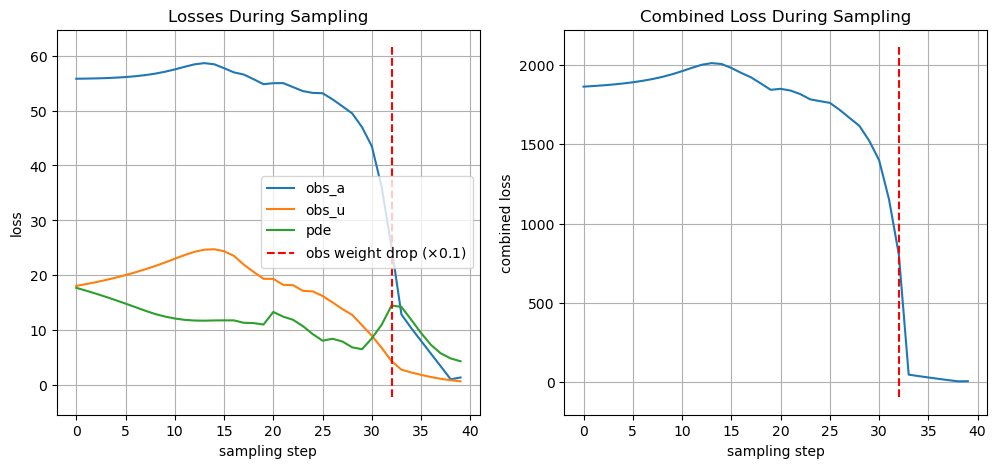

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(losses[:, :3])
axs[0].set(xlabel='sampling step', ylabel='loss', title="Losses During Sampling")
axs[0].grid()
axs[1].plot(losses[:, 3])
axs[1].set(xlabel='sampling step', ylabel='combined loss', title="Combined Loss During Sampling")
axs[1].grid()
for i in range(2):
    temp_min, temp_max = axs[i].get_ylim()
    axs[i].vlines(0.8 * num_steps, ymin=temp_min, ymax=temp_max, color='red', linestyle='--')
axs[0].legend(['obs_a', 'obs_u', 'pde', 'obs weight drop ($\\times 0.1$)'])
plt.show()

RMSE Initial Condition: 0.0126
RMSE Solution at t=0.005: 0.0947


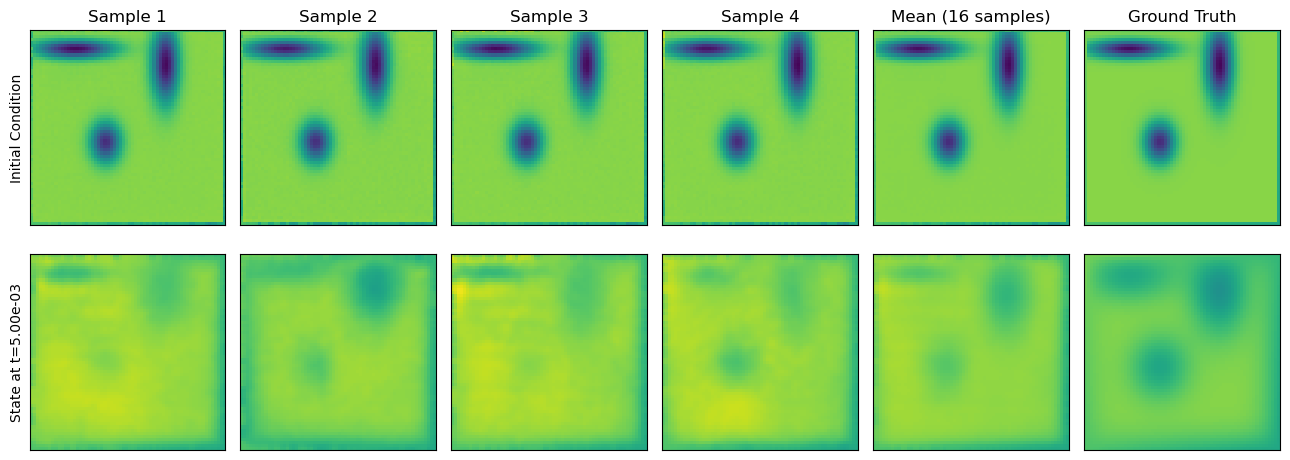

In [43]:
mean_val = samples.mean(axis=0)

vmin = min(samples[:].min(), obs_a.min(), obs_u.min())
vmax = max(samples[:].max(), obs_a.max(), obs_u.max())

print(f"RMSE Initial Condition: {torch.sqrt(torch.mean((samples[:, 0] - obs_a)**2)):.4f}")
print(f"RMSE Solution at t={T:.3f}: {torch.sqrt(torch.mean((samples[:, 1] - obs_u)**2)):.4f}")

fig, axs = plt.subplots(2, 6, figsize=(13, 5))
for i in range(4):
    axs[0, i].imshow(samples[i, 0], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[0, i].set(aspect="equal", xticks=[], yticks=[])
    axs[0, i].set_title(f'Sample {i+1}')
    if i == 0:
        axs[0, i].set_ylabel('Initial Condition')
    axs[1, i].imshow(samples[i, 1], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[1, i].set(aspect="equal", xticks=[], yticks=[])
    if i == 0:
        axs[1, i].set_ylabel(f'State at t={T:.2e}')

axs[0, 4].imshow(mean_val[0], cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 4].set(aspect="equal", xticks=[], yticks=[], title=f"Mean ({sample_shape[0]} samples)")
axs[1, 4].imshow(mean_val[1], cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 4].set(aspect="equal", xticks=[], yticks=[])

axs[0, 5].imshow(obs_a.numpy(), cmap='viridis', vmin=vmin, vmax=vmax)
axs[0, 5].set(aspect="equal", xticks=[], yticks=[], title="Ground Truth")
axs[1, 5].imshow(obs_u.numpy(), cmap='viridis', vmin=vmin, vmax=vmax)
axs[1, 5].set(aspect="equal", xticks=[], yticks=[])
plt.tight_layout()

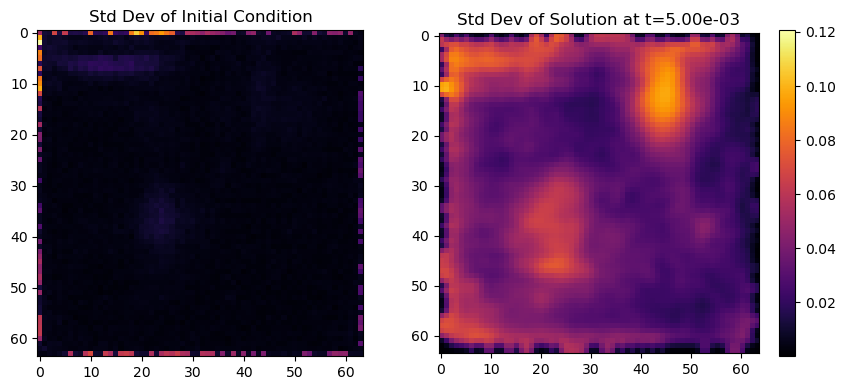

In [44]:
std = samples.std(axis=0)
vmin, vmax = min(std.min(), 1e-5), std.max()
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im0 = axs[0].imshow(std[0], cmap="inferno", vmin=vmin, vmax=vmax)
axs[0].set_title("Std Dev of Initial Condition")
im1 = axs[1].imshow(std[1], cmap="inferno", vmin=vmin, vmax=vmax)
axs[1].set_title(f"Std Dev of Solution at t={T:.2e}")
c = fig.colorbar(im1)
plt.tight_layout()  
plt.show()

In [59]:
def sampler_wrapper(params):
    zeta_a, zeta_u, zeta_pde = params
    samples, losses = edm_sampler2(
        net=edm,
        device=device,
        sample_shape=sample_shape,
        loss_fn=dpde.sampling.heat_loss,
        loss_fn_kwargs=loss_fn_kwargs,
        labels=labels,
        zeta_a=zeta_a,
        zeta_u=zeta_u,
        zeta_pde=zeta_pde,
        num_steps=num_steps,
        to_cpu=True,
        return_losses=True,
    )

    return np.sum(losses[-1, :3])

bounds = [
    (100.0, 20000.0),   # bounds for zeta_a
    (100.0, 20000.0),   # bounds for zeta_u
    (1.0, 100.0),    # bounds for zeta_pde
]

res = gp_minimize(
    sampler_wrapper,
    dimensions=bounds,
    n_calls=30,
    n_random_starts=5,
    acq_func="EI",
    random_state=0,
)   
print(f"Best parameters found: zeta_a={res.x[0]:.4f}, zeta_u={res.x[1]:.4f}, zeta_pde={res.x[2]:.4f}")

KeyboardInterrupt: 